<a href="https://colab.research.google.com/github/MarcoBarroca/VI_EAFEXP_Proj3/blob/main/master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## importar dados no cbpf placas de videos

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'#,3,4'
# import tensorflow as tf
# gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
# session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [8]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

In [9]:
dir_data = '/tf/dados/test/'
dir_notebooks = '/tf/lcs/'

In [10]:
lightcurves_train = pd.read_csv(dir_data + 'plasticc_train_lightcurves.csv.gz',compression='gzip')
metadata_train = pd.read_csv(dir_data + 'plasticc_train_metadata.csv.gz',compression='gzip')
metadata_test = pd.read_csv(dir_data + 'plasticc_test_metadata.csv.gz',compression='gzip')
lightcurves_extra = pd.read_csv(dir_data + 'plasticc_lightcurves_extra.csv.gz',compression='gzip')

##configurações para usar o colab e importações

In [12]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

###importar dados no collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# read the dataset using the compression zip
lightcurves_train = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_train_lightcurves.csv.gz',compression='gzip')
metadata_train = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_train_metadata.csv.gz',compression='gzip')
metadata_test = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_test_metadata.csv.gz',compression='gzip')
lightcurves_extra = pd.read_csv('/content/drive/MyDrive/DataP03/plasticc_lightcurves_extra.csv.gz',compression='gzip')

##Sorteia e plota uma curva de luz

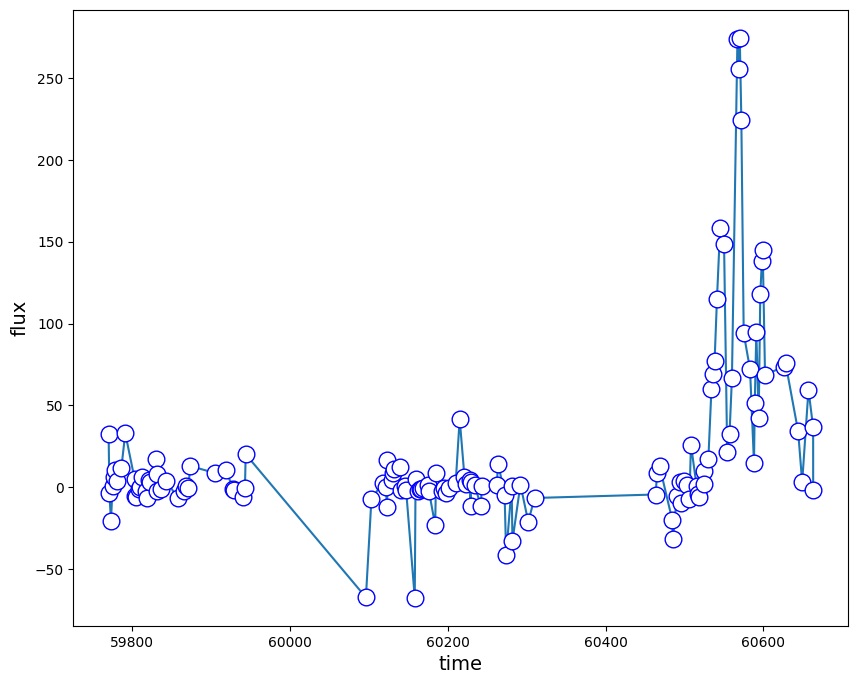

In [10]:
x = np.random.choice(metadata_train['object_id'],1)

id = lightcurves_train[np.array(lightcurves_train['object_id']) == x]

x = np.array(id['mjd'])
y = np.array(id['flux'])

plt.figure(figsize=(10,8))
plt.xlabel('time', fontsize=14)
plt.ylabel('flux', fontsize=14)
plt.plot(x,y, '.', linestyle='solid',  mec='b', markersize=24, markerfacecolor='white')
plt.show()

#converter a unidade de tempo 

##Distribuição das clases por quantidade de aparição


    unique_values  counts
11              6     151
4              15     495
3              16     924
1              42    1193
9              52     183
13             53      30
5              62     484
12             64     102
2              65     981
8              67     208
6              88     370
0              90    2313
7              92     239
10             95     175


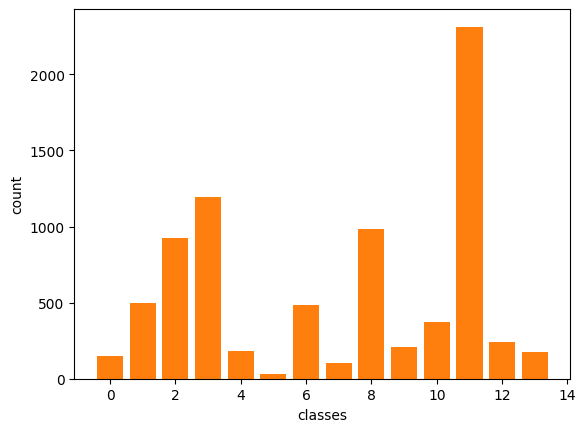

In [40]:
classes = metadata_train["target"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')
counts=[]

print(classes)
plt.bar(range(len(classes['unique_values'])),classes['counts'])
plt.xlabel('classes')
plt.ylabel('count')

plt.show()

#remover objetos vasios

[0, 1, 2, 3, 4]


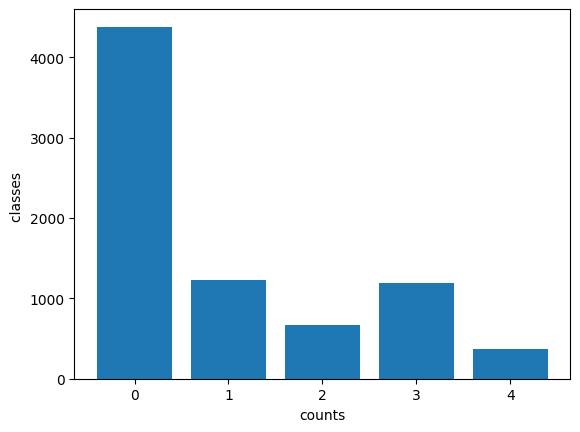

In [13]:
counts=np.unique(y.argmax(1), return_counts=True)[1]
classes=[0,1,2,3,4]
print(classes)
plt.bar(range(len(classes)),counts)
plt.xlabel('counts')
plt.ylabel('classes ')

plt.show()

##Distribuição de filtros por por quantidade de aparição

   unique_values  counts
4              0  197493
5              1  176499
2              2  238049
3              3  233520
1              4  277119
0              5  299025


1421705

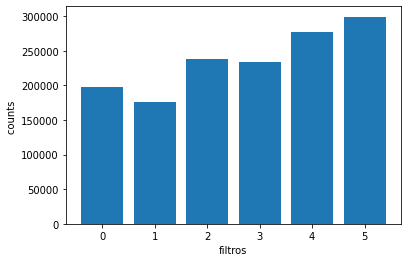

In [ ]:
filtros = lightcurves_train["passband"].value_counts().rename_axis('unique_values').reset_index(name='counts').sort_values(by='unique_values')

counts=[]

print(filtros)
plt.bar(range(len(filtros['unique_values'])),filtros['counts'])
plt.xlabel('filtros')
plt.ylabel('counts ')


sum(filtros['counts'])


##Distribuição de objetos por aparição na curva de luz

      unique_values  counts
0               615     352
1            173059     352
2            167417     352
3            167436     352
4            167488     352
...             ...     ...
7843      100413487      55
7844       68643457      52
7845      119353712      52
7846       86237249      50
7847       49575267      47

[7848 rows x 2 columns]


Text(0, 0.5, 'counts')

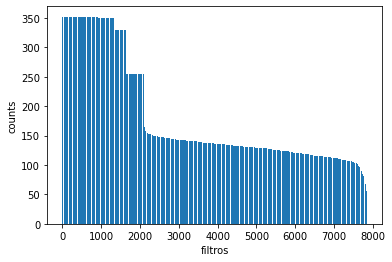

In [ ]:
pontos = lightcurves_train["object_id"].value_counts().rename_axis('unique_values').reset_index(name='counts')

counts=[]

print(pontos)
plt.bar(range(len(pontos['unique_values'])),pontos['counts'])
plt.xlabel('filtros')
plt.ylabel('counts')

#remover objetos vazios

## Separação e tratamento de dados

In [11]:
def normalize_table(tab):
    f_scaler=pre.MinMaxScaler(feature_range=(0,1)).fit(tab[:,1:3])
  #e_scaler=pre.MinMaxScaler(feature_range=(-1,1)).fit(tab[:,2])
    tab[:,1:3]=f_scaler.transform(tab[:,1:3])
  #tab[:,2]=e_scaler.transform(tab[:,2])
    tab[:,0]=tab[:,0]-np.min(tab[:,0])

    return tab

def pre_process(data_df,metadata_df):

  
    if 'Unnamed: 0' in data_df.columns:
        data_df = data_df.merge(metadata_df[['object_id', 'true_target']], how= 'inner', on = 'object_id')
    else:
        data_df = data_df.merge(metadata_df[['object_id', 'target']], how= 'inner', on = 'object_id')
    


    if 'true_target' in data_df.columns:
        data_df = data_df.rename(columns = {'true_target': 'target'}, inplace = False)


    obj_ids_def = data_df[data_df['target'] //99 != 10]
    obj_ids = obj_ids_def['object_id'].unique()
    groups = obj_ids_def.groupby(['object_id'])
    tables=[]
    y=[]
    for i,iid in enumerate(tqdm(obj_ids)):
        lines=groups.get_group(iid)
        table = lines[['mjd', 'flux', 'flux_err', 'passband','detected_bool']].values
        table = normalize_table(table)
        tables.append(table)
        y.append(lines['target'].values[0])
  
    my_dict={42: 0,
       52: 0,
       62: 0,
       67: 0,
       90: 0,
       6: 1,
       64: 1,
       65: 1,
       15: 2,
       95: 2,
       16: 3,
       53: 3,
       92: 3,
       88:4
    }
    y=[my_dict[i] for i in y]
    y = pre.LabelBinarizer().fit_transform(y)

    return tables, y

In [70]:
x,y=pre_process(lightcurves_train,metadata_train)
x_test,y_test=pre_process(lightcurves_extra,metadata_test)

  0%|          | 0/7848 [00:00<?, ?it/s]

  0%|          | 0/19920 [00:00<?, ?it/s]

In [11]:
print(y)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [73]:
pad_x=tf.keras.preprocessing.sequence.pad_sequences(x,value=-99 ,maxlen=352, padding='post',dtype=np.float32)
pad_x_test=tf.keras.preprocessing.sequence.pad_sequences(x_test,value=-99 ,maxlen=352, padding='post',dtype=np.float32)
np.any(np.diff(pad_x[:,:,0])) <0 

False

In [82]:
pad_x_test.shape

(19920, 352, 5)

In [ ]:
#salvar dados no drive
np.save('/content/drive/MyDrive/Data_numpy/pad_x_train.npy',pad_x_train)
np.save('/content/drive/MyDrive/Data_numpy/pad_x_test.npy',pad_x_test)

##Carregar arquivos tratados do drive

In [13]:
# load numpy array from npy file
pad_x_train = np.load('/content/drive/MyDrive/Data_numpy/pad_x_train.npy')
pad_x_test = np.load('/content/drive/MyDrive/Data_numpy/pad_x_train.npy')

In [11]:
np.any(np.diff(pad_x_train[:,:,0])) <0 

False

##Separação de dados de test, train e validation

In [78]:
x_train, x_valid, y_train, y_valid = train_test_split(pad_x, y, test_size=0.10, random_state=42)

In [15]:
sum(counts)/counts

array([ 1.79137183,  6.35980551, 11.71343284,  6.57837385, 21.21081081])

In [39]:
counts=np.unique(y.argmax(1), return_counts=True)[1]

class_weight={0:np.sum(counts)/counts[0],
             1:np.sum(counts)/counts[1],
             2:np.sum(counts)/counts[2],
             3:np.sum(counts)/counts[3],
             4:np.sum(counts)/counts[4]
    }
norm=np.linalg.norm(np.array([np.sum(counts)/counts[0],
             np.sum(counts)/counts[1],
             np.sum(counts)/counts[2],
             np.sum(counts)/counts[3],
             np.sum(counts)/counts[4]]
                             

class_weight_n={0:class_weight[0]/norm,
                1:class_weight[1]/norm,
                2:class_weight[2]/norm,
                3:class_weight[3]/norm,
                4:class_weight[4]/norm
               }

class_weight_n

{0: 0.06899932, 1: 0.24496435, 2: 0.45117315, 3: 0.25338307, 4: 0.81698921}

## Treinamento e preparação da rede 

In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, GlobalMaxPool1D
from tensorflow.keras.layers import Dense, Masking, Bidirectional, Conv1D,MaxPool1D
import keras
n_features=5
n_classes=5
n_meas=352

model = Sequential()
model.add(Masking(mask_value=-99, input_shape=(n_meas, n_features)))

#model.add(Conv1D(filters=32,kernel_size=2,activation='swish',input_shape=(352, 5)))
#model.add(MaxPool1D())
#model.add(Conv1D(filters=64,kernel_size=2,activation='swish'))
#model.add(MaxPool1D())


model.add(TimeDistributed(Dense(300,activation='swish')))#input_shape=(352, 4))))
model.add(TimeDistributed(Dense(200,activation='swish')))

model.add(Bidirectional(LSTM(512, activation='tanh', return_sequences=True),merge_mode='concat'))
#model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(256, activation='tanh', return_sequences=True),merge_mode='concat'))

model.add(GlobalMaxPool1D())
#model.add(Dropout(0.2))

model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='Softmax'))

optimizer = tf.optimizers.Adam(learning_rate=0.01)
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics = METRICS)


callbacks = [
    EarlyStopping(patience=20, verbose=1,restore_best_weights=True),
    #ModelCheckpoint(dir_data+'models/model02.h5', verbose=1, save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', verbose=1,factor=0.20,
                              patience=10, min_lr=0.00001)
]


# fit model
EPOCHS = 200
BATCH_SIZE = 64

history = model.fit(x=x_train,
                    y=y_train,
                        validation_data=(x_valid, y_valid),
                        epochs=EPOCHS,
                      callbacks=callbacks,
                        batch_size=BATCH_SIZE,
                    #class_weight=class_weight_n
                    )
     

Epoch 1/200
111/111 [==============================] - 33s 192ms/step - loss: 1.4391 - tp: 2757.0000 - fp: 2172.0000 - tn: 26080.0000 - fn: 4306.0000 - accuracy: 0.8166 - precision: 0.5593 - recall: 0.3903 - auc: 0.7558 - prc: 0.4487 - val_loss: 1.3123 - val_tp: 416.0000 - val_fp: 369.0000 - val_tn: 2771.0000 - val_fn: 369.0000 - val_accuracy: 0.8120 - val_precision: 0.5299 - val_recall: 0.5299 - val_auc: 0.7811 - val_prc: 0.5012 - lr: 0.0100
Epoch 2/200
111/111 [==============================] - 16s 142ms/step - loss: 1.2232 - tp: 3193.0000 - fp: 2059.0000 - tn: 26193.0000 - fn: 3870.0000 - accuracy: 0.8321 - precision: 0.6080 - recall: 0.4521 - auc: 0.8040 - prc: 0.5195 - val_loss: 1.1985 - val_tp: 367.0000 - val_fp: 241.0000 - val_tn: 2899.0000 - val_fn: 418.0000 - val_accuracy: 0.8321 - val_precision: 0.6036 - val_recall: 0.4675 - val_auc: 0.8209 - val_prc: 0.5268 - lr: 0.0100
Epoch 3/200
111/111 [==============================] - 16s 144ms/step - loss: 1.1573 - tp: 3391.0000 - fp:

Epoch 19/200
111/111 [==============================] - 16s 145ms/step - loss: 1.0813 - tp: 3865.0000 - fp: 2140.0000 - tn: 26112.0000 - fn: 3198.0000 - accuracy: 0.8488 - precision: 0.6436 - recall: 0.5472 - auc: 0.8460 - prc: 0.5737 - val_loss: 1.1190 - val_tp: 426.0000 - val_fp: 264.0000 - val_tn: 2876.0000 - val_fn: 359.0000 - val_accuracy: 0.8413 - val_precision: 0.6174 - val_recall: 0.5427 - val_auc: 0.8338 - val_prc: 0.5521 - lr: 0.0020
Epoch 20/200
111/111 [==============================] - 16s 144ms/step - loss: 1.0860 - tp: 3830.0000 - fp: 2184.0000 - tn: 26068.0000 - fn: 3233.0000 - accuracy: 0.8466 - precision: 0.6368 - recall: 0.5423 - auc: 0.8450 - prc: 0.5728 - val_loss: 1.1252 - val_tp: 371.0000 - val_fp: 236.0000 - val_tn: 2904.0000 - val_fn: 414.0000 - val_accuracy: 0.8344 - val_precision: 0.6112 - val_recall: 0.4726 - val_auc: 0.8361 - val_prc: 0.5523 - lr: 0.0020
Epoch 21/200
111/111 [==============================] - 16s 145ms/step - loss: 1.0924 - tp: 3829.0000 - 

111/111 [==============================] - 16s 146ms/step - loss: 1.0723 - tp: 3800.0000 - fp: 2127.0000 - tn: 26125.0000 - fn: 3263.0000 - accuracy: 0.8474 - precision: 0.6411 - recall: 0.5380 - auc: 0.8491 - prc: 0.5822 - val_loss: 1.1246 - val_tp: 369.0000 - val_fp: 226.0000 - val_tn: 2914.0000 - val_fn: 416.0000 - val_accuracy: 0.8364 - val_precision: 0.6202 - val_recall: 0.4701 - val_auc: 0.8389 - val_prc: 0.5720 - lr: 0.0020
Epoch 38/200
111/111 [==============================] - 16s 146ms/step - loss: 1.0705 - tp: 3867.0000 - fp: 2124.0000 - tn: 26128.0000 - fn: 3196.0000 - accuracy: 0.8494 - precision: 0.6455 - recall: 0.5475 - auc: 0.8490 - prc: 0.5851 - val_loss: 1.1154 - val_tp: 329.0000 - val_fp: 177.0000 - val_tn: 2963.0000 - val_fn: 456.0000 - val_accuracy: 0.8387 - val_precision: 0.6502 - val_recall: 0.4191 - val_auc: 0.8389 - val_prc: 0.5726 - lr: 0.0020
Epoch 39/200
111/111 [==============================] - 16s 146ms/step - loss: 1.0668 - tp: 3806.0000 - fp: 2090.0000

111/111 [==============================] - 16s 144ms/step - loss: 1.0613 - tp: 3853.0000 - fp: 2114.0000 - tn: 26138.0000 - fn: 3210.0000 - accuracy: 0.8492 - precision: 0.6457 - recall: 0.5455 - auc: 0.8522 - prc: 0.5923 - val_loss: 1.0952 - val_tp: 446.0000 - val_fp: 266.0000 - val_tn: 2874.0000 - val_fn: 339.0000 - val_accuracy: 0.8459 - val_precision: 0.6264 - val_recall: 0.5682 - val_auc: 0.8474 - val_prc: 0.5991 - lr: 0.0020
Epoch 56/200
111/111 [==============================] - 16s 144ms/step - loss: 1.0355 - tp: 3886.0000 - fp: 2031.0000 - tn: 26221.0000 - fn: 3177.0000 - accuracy: 0.8525 - precision: 0.6568 - recall: 0.5502 - auc: 0.8597 - prc: 0.6133 - val_loss: 1.0619 - val_tp: 445.0000 - val_fp: 234.0000 - val_tn: 2906.0000 - val_fn: 340.0000 - val_accuracy: 0.8538 - val_precision: 0.6554 - val_recall: 0.5669 - val_auc: 0.8563 - val_prc: 0.6163 - lr: 0.0020
Epoch 57/200
111/111 [==============================] - 16s 146ms/step - loss: 1.0193 - tp: 4009.0000 - fp: 1973.0000

Epoch 73/200
111/111 [==============================] - 16s 145ms/step - loss: 0.9585 - tp: 3992.0000 - fp: 1708.0000 - tn: 26544.0000 - fn: 3071.0000 - accuracy: 0.8647 - precision: 0.7004 - recall: 0.5652 - auc: 0.8808 - prc: 0.6689 - val_loss: 1.0119 - val_tp: 454.0000 - val_fp: 224.0000 - val_tn: 2916.0000 - val_fn: 331.0000 - val_accuracy: 0.8586 - val_precision: 0.6696 - val_recall: 0.5783 - val_auc: 0.8706 - val_prc: 0.6434 - lr: 4.0000e-04
Epoch 74/200
111/111 [==============================] - 16s 146ms/step - loss: 0.9522 - tp: 4010.0000 - fp: 1706.0000 - tn: 26546.0000 - fn: 3053.0000 - accuracy: 0.8652 - precision: 0.7015 - recall: 0.5677 - auc: 0.8824 - prc: 0.6759 - val_loss: 0.9994 - val_tp: 441.0000 - val_fp: 211.0000 - val_tn: 2929.0000 - val_fn: 344.0000 - val_accuracy: 0.8586 - val_precision: 0.6764 - val_recall: 0.5618 - val_auc: 0.8721 - val_prc: 0.6513 - lr: 4.0000e-04
Epoch 75/200
111/111 [==============================] - 16s 146ms/step - loss: 0.9481 - tp: 4001

111/111 [==============================] - 16s 144ms/step - loss: 0.9166 - tp: 4103.0000 - fp: 1609.0000 - tn: 26643.0000 - fn: 2960.0000 - accuracy: 0.8706 - precision: 0.7183 - recall: 0.5809 - auc: 0.8905 - prc: 0.6946 - val_loss: 0.9691 - val_tp: 469.0000 - val_fp: 208.0000 - val_tn: 2932.0000 - val_fn: 316.0000 - val_accuracy: 0.8665 - val_precision: 0.6928 - val_recall: 0.5975 - val_auc: 0.8816 - val_prc: 0.6689 - lr: 4.0000e-04
Epoch 92/200
111/111 [==============================] - 16s 144ms/step - loss: 0.9033 - tp: 4126.0000 - fp: 1547.0000 - tn: 26705.0000 - fn: 2937.0000 - accuracy: 0.8730 - precision: 0.7273 - recall: 0.5842 - auc: 0.8942 - prc: 0.7043 - val_loss: 0.9733 - val_tp: 478.0000 - val_fp: 215.0000 - val_tn: 2925.0000 - val_fn: 307.0000 - val_accuracy: 0.8670 - val_precision: 0.6898 - val_recall: 0.6089 - val_auc: 0.8794 - val_prc: 0.6622 - lr: 4.0000e-04
Epoch 93/200
111/111 [==============================] - 16s 147ms/step - loss: 0.9009 - tp: 4169.0000 - fp: 1

111/111 [==============================] - 16s 145ms/step - loss: 0.7955 - tp: 4644.0000 - fp: 1430.0000 - tn: 26822.0000 - fn: 2419.0000 - accuracy: 0.8910 - precision: 0.7646 - recall: 0.6575 - auc: 0.9186 - prc: 0.7675 - val_loss: 0.8547 - val_tp: 505.0000 - val_fp: 169.0000 - val_tn: 2971.0000 - val_fn: 280.0000 - val_accuracy: 0.8856 - val_precision: 0.7493 - val_recall: 0.6433 - val_auc: 0.9073 - val_prc: 0.7278 - lr: 4.0000e-04
Epoch 110/200
111/111 [==============================] - 16s 145ms/step - loss: 0.7565 - tp: 4745.0000 - fp: 1325.0000 - tn: 26927.0000 - fn: 2318.0000 - accuracy: 0.8968 - precision: 0.7817 - recall: 0.6718 - auc: 0.9264 - prc: 0.7870 - val_loss: 0.8743 - val_tp: 487.0000 - val_fp: 180.0000 - val_tn: 2960.0000 - val_fn: 298.0000 - val_accuracy: 0.8782 - val_precision: 0.7301 - val_recall: 0.6204 - val_auc: 0.9043 - val_prc: 0.7246 - lr: 4.0000e-04
Epoch 111/200
111/111 [==============================] - 16s 146ms/step - loss: 0.7477 - tp: 4761.0000 - fp:

111/111 [==============================] - 16s 145ms/step - loss: 0.6700 - tp: 5097.0000 - fp: 1239.0000 - tn: 27013.0000 - fn: 1966.0000 - accuracy: 0.9092 - precision: 0.8045 - recall: 0.7216 - auc: 0.9416 - prc: 0.8225 - val_loss: 0.7709 - val_tp: 552.0000 - val_fp: 158.0000 - val_tn: 2982.0000 - val_fn: 233.0000 - val_accuracy: 0.9004 - val_precision: 0.7775 - val_recall: 0.7032 - val_auc: 0.9234 - val_prc: 0.7802 - lr: 4.0000e-04
Epoch 128/200
111/111 [==============================] - 16s 146ms/step - loss: 0.6444 - tp: 5146.0000 - fp: 1179.0000 - tn: 27073.0000 - fn: 1917.0000 - accuracy: 0.9123 - precision: 0.8136 - recall: 0.7286 - auc: 0.9465 - prc: 0.8367 - val_loss: 0.8154 - val_tp: 539.0000 - val_fp: 175.0000 - val_tn: 2965.0000 - val_fn: 246.0000 - val_accuracy: 0.8927 - val_precision: 0.7549 - val_recall: 0.6866 - val_auc: 0.9188 - val_prc: 0.7635 - lr: 4.0000e-04
Epoch 129/200
111/111 [==============================] - 16s 145ms/step - loss: 0.7455 - tp: 4844.0000 - fp:

111/111 [==============================] - 16s 146ms/step - loss: 0.5299 - tp: 5458.0000 - fp: 1055.0000 - tn: 27197.0000 - fn: 1605.0000 - accuracy: 0.9247 - precision: 0.8380 - recall: 0.7728 - auc: 0.9633 - prc: 0.8798 - val_loss: 0.6927 - val_tp: 574.0000 - val_fp: 158.0000 - val_tn: 2982.0000 - val_fn: 211.0000 - val_accuracy: 0.9060 - val_precision: 0.7842 - val_recall: 0.7312 - val_auc: 0.9391 - val_prc: 0.8081 - lr: 4.0000e-04
Epoch 146/200
111/111 [==============================] - 16s 144ms/step - loss: 0.5359 - tp: 5475.0000 - fp: 1093.0000 - tn: 27159.0000 - fn: 1588.0000 - accuracy: 0.9241 - precision: 0.8336 - recall: 0.7752 - auc: 0.9621 - prc: 0.8781 - val_loss: 0.6686 - val_tp: 574.0000 - val_fp: 155.0000 - val_tn: 2985.0000 - val_fn: 211.0000 - val_accuracy: 0.9068 - val_precision: 0.7874 - val_recall: 0.7312 - val_auc: 0.9423 - val_prc: 0.8152 - lr: 4.0000e-04
Epoch 147/200
111/111 [==============================] - 16s 143ms/step - loss: 0.5157 - tp: 5539.0000 - fp:

111/111 [==============================] - 16s 143ms/step - loss: 0.4977 - tp: 5594.0000 - fp: 1008.0000 - tn: 27244.0000 - fn: 1469.0000 - accuracy: 0.9299 - precision: 0.8473 - recall: 0.7920 - auc: 0.9672 - prc: 0.8931 - val_loss: 0.6331 - val_tp: 598.0000 - val_fp: 150.0000 - val_tn: 2990.0000 - val_fn: 187.0000 - val_accuracy: 0.9141 - val_precision: 0.7995 - val_recall: 0.7618 - val_auc: 0.9483 - val_prc: 0.8282 - lr: 4.0000e-04
Epoch 164/200
111/111 [==============================] - 16s 143ms/step - loss: 0.4885 - tp: 5647.0000 - fp: 1019.0000 - tn: 27233.0000 - fn: 1416.0000 - accuracy: 0.9310 - precision: 0.8471 - recall: 0.7995 - auc: 0.9681 - prc: 0.8942 - val_loss: 0.6776 - val_tp: 578.0000 - val_fp: 156.0000 - val_tn: 2984.0000 - val_fn: 207.0000 - val_accuracy: 0.9075 - val_precision: 0.7875 - val_recall: 0.7363 - val_auc: 0.9418 - val_prc: 0.8122 - lr: 4.0000e-04
Epoch 165/200
111/111 [==============================] - 16s 144ms/step - loss: 0.4838 - tp: 5644.0000 - fp:

111/111 [==============================] - 16s 144ms/step - loss: 0.3816 - tp: 5965.0000 - fp: 810.0000 - tn: 27442.0000 - fn: 1098.0000 - accuracy: 0.9460 - precision: 0.8804 - recall: 0.8445 - auc: 0.9806 - prc: 0.9334 - val_loss: 0.6158 - val_tp: 613.0000 - val_fp: 141.0000 - val_tn: 2999.0000 - val_fn: 172.0000 - val_accuracy: 0.9203 - val_precision: 0.8130 - val_recall: 0.7809 - val_auc: 0.9506 - val_prc: 0.8387 - lr: 8.0000e-05
Epoch 181/200
111/111 [==============================] - 16s 145ms/step - loss: 0.3811 - tp: 5968.0000 - fp: 806.0000 - tn: 27446.0000 - fn: 1095.0000 - accuracy: 0.9462 - precision: 0.8810 - recall: 0.8450 - auc: 0.9807 - prc: 0.9332 - val_loss: 0.6306 - val_tp: 601.0000 - val_fp: 150.0000 - val_tn: 2990.0000 - val_fn: 184.0000 - val_accuracy: 0.9149 - val_precision: 0.8003 - val_recall: 0.7656 - val_auc: 0.9492 - val_prc: 0.8349 - lr: 8.0000e-05
Epoch 182/200
111/111 [==============================] - 16s 144ms/step - loss: 0.3833 - tp: 5964.0000 - fp: 8

Epoch 198/200
111/111 [==============================] - 16s 144ms/step - loss: 0.3384 - tp: 6060.0000 - fp: 731.0000 - tn: 27521.0000 - fn: 1003.0000 - accuracy: 0.9509 - precision: 0.8924 - recall: 0.8580 - auc: 0.9850 - prc: 0.9478 - val_loss: 0.6093 - val_tp: 603.0000 - val_fp: 144.0000 - val_tn: 2996.0000 - val_fn: 182.0000 - val_accuracy: 0.9169 - val_precision: 0.8072 - val_recall: 0.7682 - val_auc: 0.9527 - val_prc: 0.8436 - lr: 1.6000e-05
Epoch 199/200
111/111 [==============================] - 16s 145ms/step - loss: 0.3359 - tp: 6083.0000 - fp: 717.0000 - tn: 27535.0000 - fn: 980.0000 - accuracy: 0.9519 - precision: 0.8946 - recall: 0.8612 - auc: 0.9851 - prc: 0.9485 - val_loss: 0.6080 - val_tp: 606.0000 - val_fp: 146.0000 - val_tn: 2994.0000 - val_fn: 179.0000 - val_accuracy: 0.9172 - val_precision: 0.8059 - val_recall: 0.7720 - val_auc: 0.9526 - val_prc: 0.8428 - lr: 1.6000e-05
Epoch 200/200
111/111 [==============================] - 16s 145ms/step - loss: 0.3319 - tp: 6100

In [11]:
tf.__version__

'2.8.0'

In [90]:
#salva modelo
model.save(dir_data+'models/model05')
model.save_weights(dir_data+'models/model05/model_weights')#alteração de caminhos talvez seja nessaria

INFO:tensorflow:Assets written to: /tf/dados/test/models/model05/assets


INFO:tensorflow:Assets written to: /tf/dados/test/models/model05/assets


###Importa modelo já treinado anteriomente

In [33]:
# importa modelo já treinado
model = tf.keras.models.load_model(dir_data+'/models/model01') #alteração de caminhos talvez seja nessaria

In [87]:
for layer in model.layers:
    
    print(layer.get_config())

{'name': 'masking_1', 'trainable': True, 'batch_input_shape': (None, 352, 5), 'dtype': 'float32', 'mask_value': -99}
{'name': 'time_distributed_10', 'trainable': True, 'dtype': 'float32', 'layer': {'class_name': 'Dense', 'config': {'name': 'dense_20', 'trainable': True, 'dtype': 'float32', 'units': 300, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}}
{'name': 'time_distributed_11', 'trainable': True, 'dtype': 'float32', 'layer': {'class_name': 'Dense', 'config': {'name': 'dense_21', 'trainable': True, 'dtype': 'float32', 'units': 200, 'activation': 'swish', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel

##Analise dos resultados

###Grafico loss x epochs

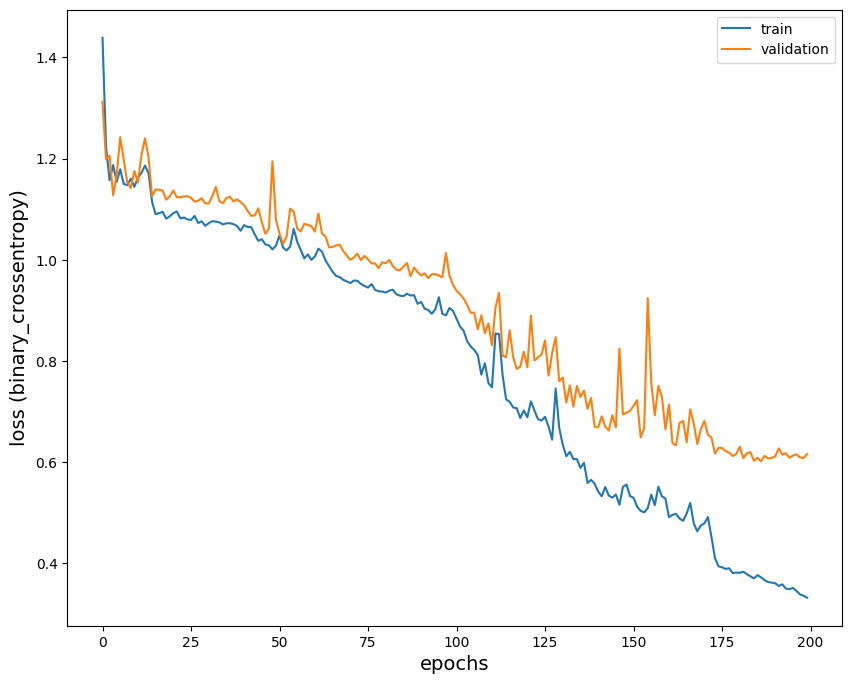

In [91]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')

plt.xlabel('epochs', fontsize=14)
plt.ylabel('loss (binary_crossentropy)', fontsize=14)
plt.legend()
plt.show()

###Curva Roc

In [92]:
from sklearn import metrics as met
pred = model.predict(pad_x_test)
pred_valid=model.predict(x_valid)
pred_train=model.predict(x_train)

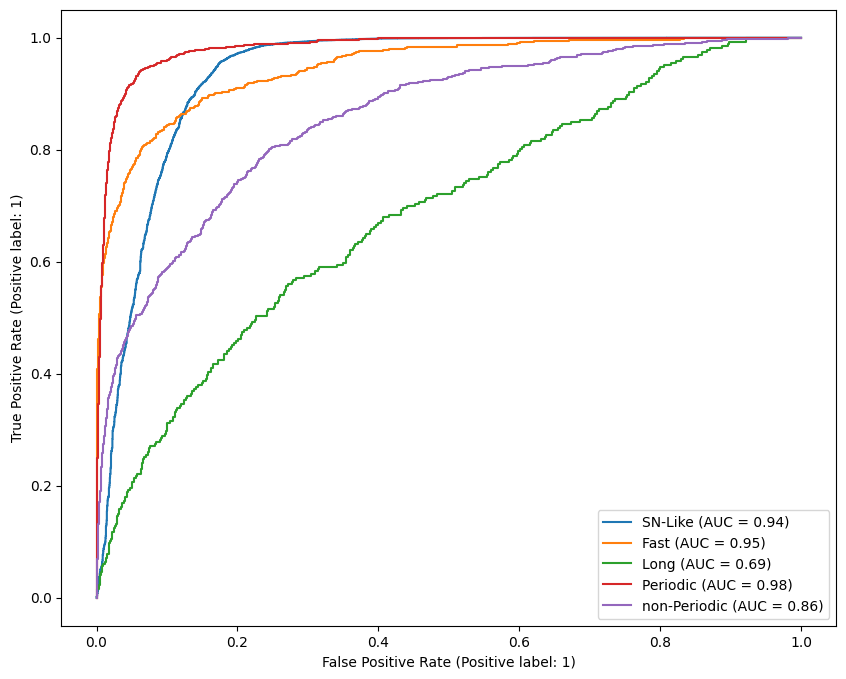

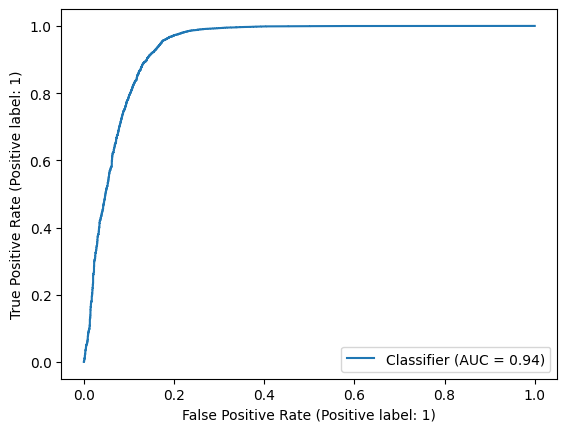

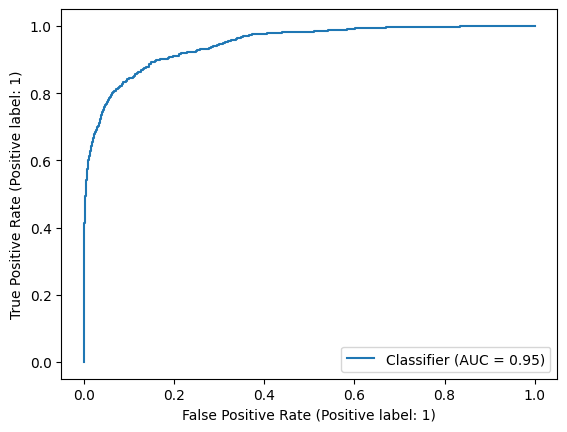

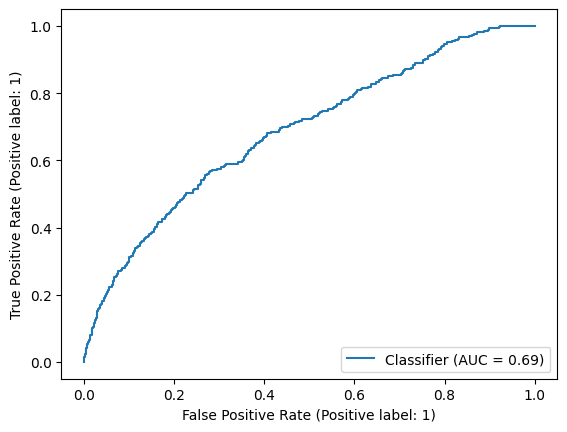

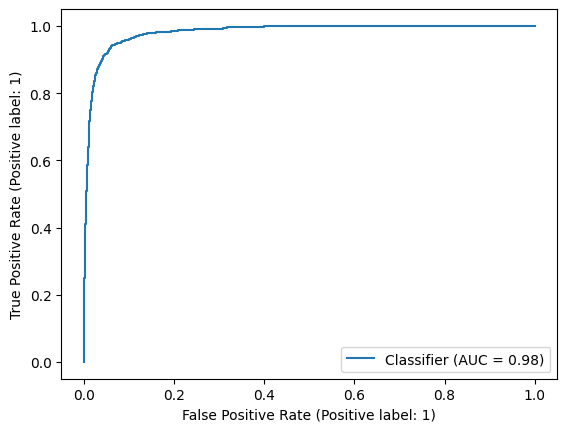

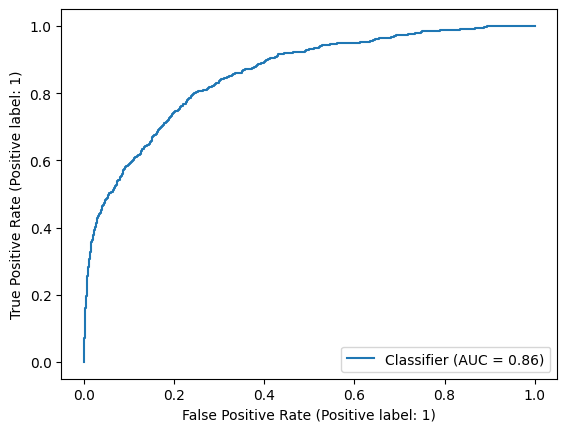

In [93]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
names = ['SN-Like', 'Fast', 'Long', 'Periodic', 'non-Periodic']
for x in range(5):
    display = met.RocCurveDisplay.from_predictions(y_test[:,x],pred[:,x])#,  pos_label='None')
    display.plot(ax, name=f'{names[x]}')
plt.show()

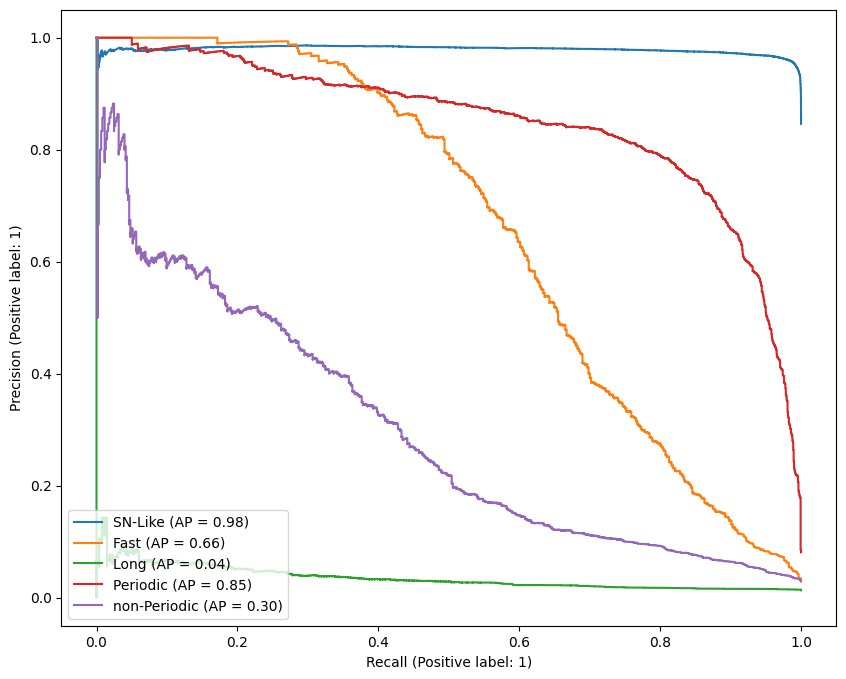

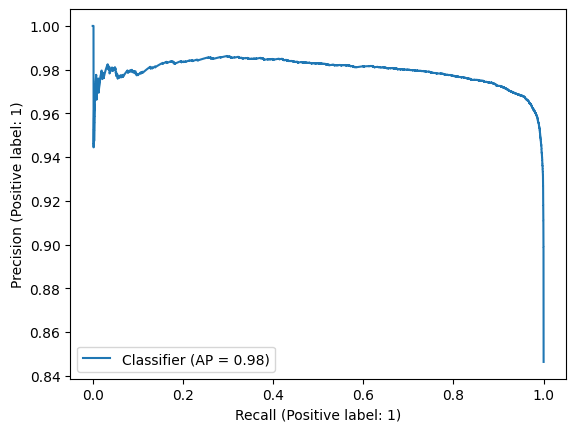

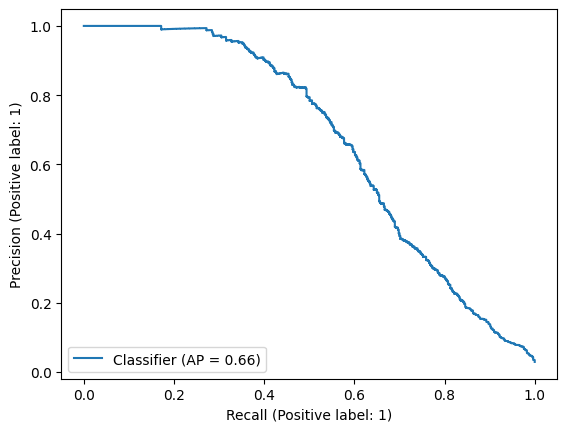

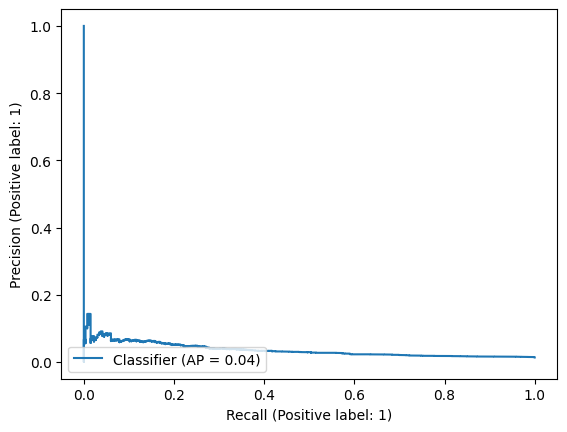

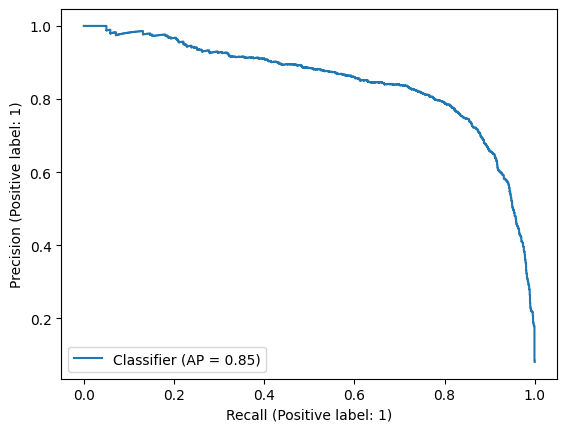

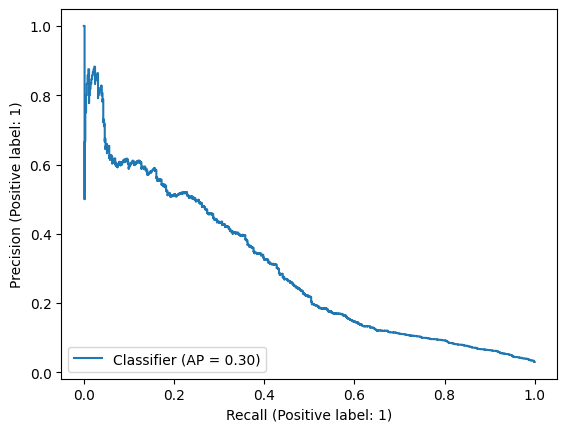

In [94]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
for x in range(5):
    display = met.PrecisionRecallDisplay.from_predictions(y_test[:,x],pred[:,x])#,  pos_label='None')
    display.plot(ax, name=f'{names[x]}')
plt.show()

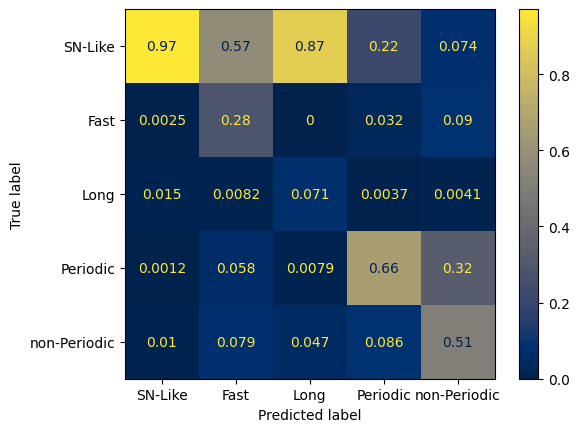

In [95]:

met.ConfusionMatrixDisplay.from_predictions(y_test.argmax(1),pred.argmax(1),normalize='pred',display_labels=names,cmap='cividis')

plt.show()

### Matrix de confusão

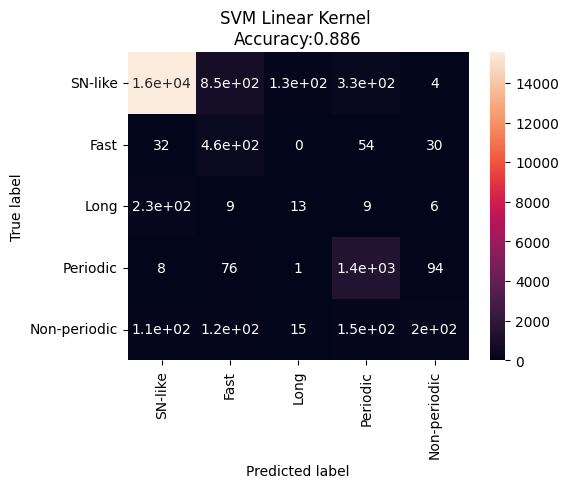

In [54]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns


y_test_arg= np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(pad_x_test),axis=1)



# Creates a confusion matrix
cm = confusion_matrix(y_test_arg, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['SN-like','Fast','Long','Periodic','Non-periodic'], 
                     columns = ['SN-like','Fast','Long','Periodic','Non-periodic'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test_arg, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [33]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 44.8 MB/s eta 0:00:00
